In [12]:
from pathlib import Path
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [13]:
processed_data_dir = Path("data/processed")
interim_data_dir = Path("data/interim")

df = pd.read_csv(interim_data_dir / "02_data.csv")
print("Full preprocessed dataframe:", df.shape)
print(df.head())

X_train = pd.read_csv(processed_data_dir / "X_train.csv")
X_val   = pd.read_csv(processed_data_dir / "X_val.csv")
X_test  = pd.read_csv(processed_data_dir / "X_test.csv")

y_train = pd.read_csv(processed_data_dir / "y_train.csv").squeeze("columns")
y_val   = pd.read_csv(processed_data_dir / "y_val.csv").squeeze("columns")
y_test  = pd.read_csv(processed_data_dir / "y_test.csv").squeeze("columns")

print("Train split:", X_train.shape, y_train.shape)
print("Validation split:", X_val.shape, y_val.shape)
print("Test split:", X_test.shape, y_test.shape)

Full preprocessed dataframe: (54170, 26)
              DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  \
0  2019-01-01 00:00:00         6352        6527     1395    79           1383   
1  2019-01-01 01:00:00         6116        5701     1393    96           1112   
2  2019-01-01 02:00:00         5873        5676     1393   142           1030   
3  2019-01-01 03:00:00         5682        5603     1397   191            972   
4  2019-01-01 04:00:00         5557        5454     1393   159            960   

   Oil and Gas  Coal  Solar  Biomass  ...  demand_High  hour day_of_week  \
0         1896  1744      0       30  ...        False     0           1   
1         1429  1641      0       30  ...        False     1           1   
2         1465  1616      0       30  ...        False     2           1   
3         1455  1558      0       30  ...        False     3           1   
4         1454  1458      0       30  ...        False     4           1   

   month  hour_

In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels=None, results_dict=None):
    """
    Train, evaluate, and optionally log results for a given model.
    
    Args:
        model: sklearn-compatible model
        X_train, y_train: training data
        X_test, y_test: test data
        labels: list of class labels for reporting
        results_dict: optional dictionary to log results (e.g., for comparison)
    
    Returns:
        y_pred: predictions on the test set
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Report
    print(f"=== {model.__class__.__name__} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.show()
    
    # Log results
    if results_dict is not None:
        results_dict[model.__class__.__name__] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "macro_f1": f1_score(y_test, y_pred, average="macro")
        }
    
    return y_pred

In [15]:
labels = ["Low", "Medium", "High"]
results = {}

In [ ]:
def establish_baselines(X_train, y_train, X_test, y_test, cv_folds=5):
    """Establish comprehensive classification baselines"""
 
    # Level 1: Dummy baselines
    dummy_strategies = ['most_frequent', 'stratified', 'uniform']
    for strategy in dummy_strategies:
        dummy = DummyClassifier(strategy=strategy, random_state=42)
        evaluate_model(dummy, X_train, y_train, X_test, y_test, labels, results)
    
    # Level 2: Simple models
    simple_models = [
        LogisticRegression(random_state=42, max_iter=1000),
        DecisionTreeClassifier(max_depth=5, random_state=42)
    ]
    for model in simple_models:
        evaluate_model(model, X_train, y_train, X_test, y_test, labels, results)

=== DummyClassifier ===
Accuracy: 0.33339486800812257
Macro F1: 0.16668974110480408

Classification Report:

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00      3612
      Medium       0.33      1.00      0.50      3612
        High       0.00      0.00      0.00      3610

    accuracy                           0.33     10834
   macro avg       0.11      0.33      0.17     10834
weighted avg       0.11      0.33      0.17     10834



/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/nix/store/dp8mgzs0rvjhl5hr5ka0vqan7sidrhad-python3-3.13.5-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

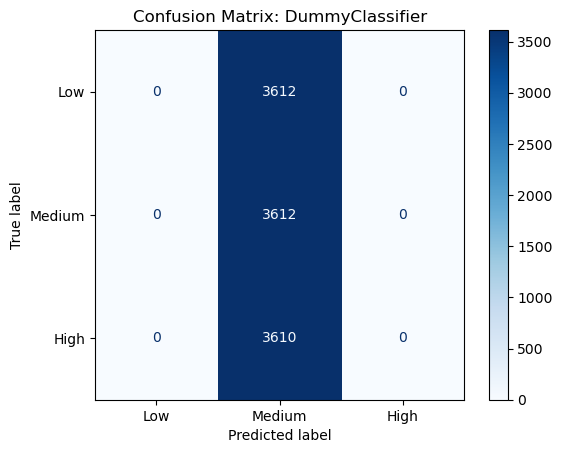

=== DummyClassifier ===
Accuracy: 0.33902529075133836
Macro F1: 0.33902815125418045

Classification Report:

              precision    recall  f1-score   support

         Low       0.34      0.34      0.34      3612
      Medium       0.34      0.34      0.34      3612
        High       0.34      0.34      0.34      3610

    accuracy                           0.34     10834
   macro avg       0.34      0.34      0.34     10834
weighted avg       0.34      0.34      0.34     10834



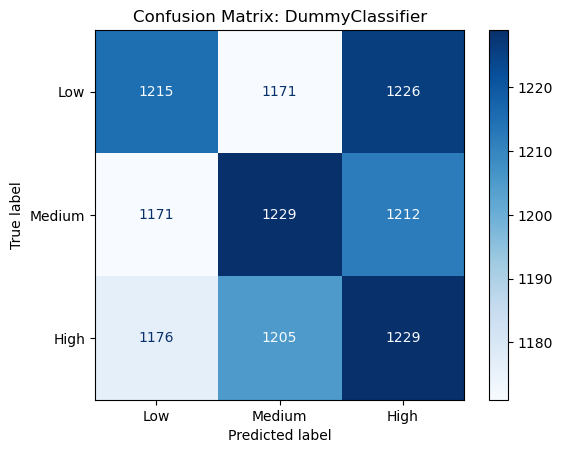

=== DummyClassifier ===
Accuracy: 0.335148606239616
Macro F1: 0.3351727141062266

Classification Report:

              precision    recall  f1-score   support

         Low       0.33      0.33      0.33      3612
      Medium       0.33      0.33      0.33      3612
        High       0.34      0.34      0.34      3610

    accuracy                           0.34     10834
   macro avg       0.34      0.34      0.34     10834
weighted avg       0.34      0.34      0.34     10834



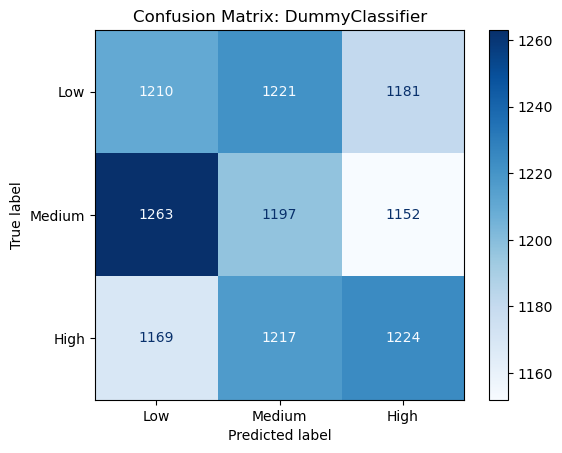

=== LogisticRegression ===
Accuracy: 0.6005168912682296
Macro F1: 0.5935477924357723

Classification Report:

              precision    recall  f1-score   support

         Low       0.66      0.71      0.69      3612
      Medium       0.47      0.39      0.43      3612
        High       0.64      0.70      0.67      3610

    accuracy                           0.60     10834
   macro avg       0.59      0.60      0.59     10834
weighted avg       0.59      0.60      0.59     10834



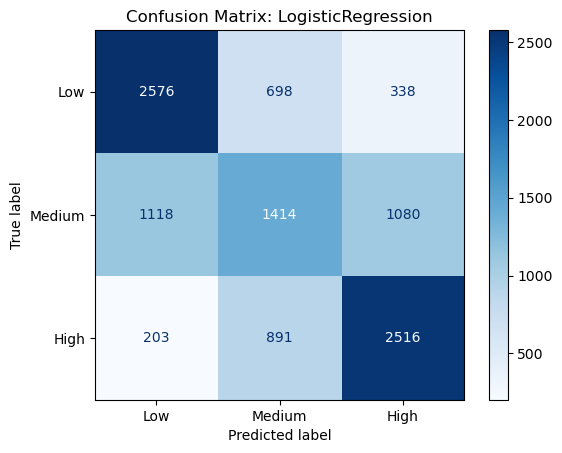

=== DecisionTreeClassifier ===
Accuracy: 0.6822041720509507
Macro F1: 0.6793471233708605

Classification Report:

              precision    recall  f1-score   support

         Low       0.79      0.71      0.75      3612
      Medium       0.57      0.52      0.54      3612
        High       0.69      0.82      0.75      3610

    accuracy                           0.68     10834
   macro avg       0.68      0.68      0.68     10834
weighted avg       0.68      0.68      0.68     10834



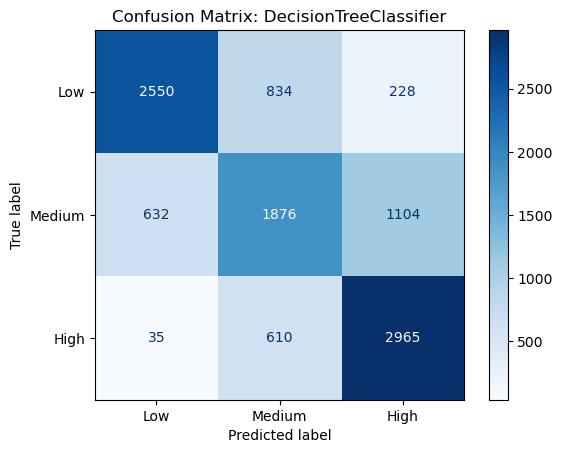

In [20]:
establish_baselines(X_train, y_train, X_test, y_test)